In [5]:
pip install torchinfo


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [114]:
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



 frog  deer plane   dog


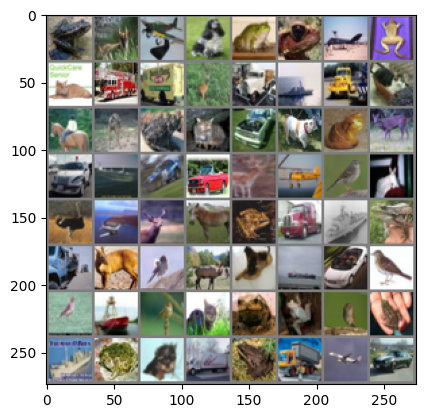

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [116]:
import torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        # Block 1: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x16x16
        # Block 2: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(128)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128x8x8
        # Block 3: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
        # Increased filters slightly more
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(256)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 256x4x4
        # Global Average Pooling
        # Reduces 256x4x4 to 256 features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Classifier
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        # Final Linear layer for 10 classes
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        # Global Average Pooling
        x = self.avgpool(x)
        # Flatten the spatial dimensions (from 256x1x1 to 256)
        x = torch.flatten(x, 1)
        # Classifier
        x = self.dropout(x) # Apply dropout before the final layer
        x = self.fc(x)
        return x

model = CIFAR10_CNN()
summary(model, input_size=(1, 3, 32, 32))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR10_CNN                              [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64
├─Conv2d: 1-3                            [1, 64, 32, 32]           18,496
├─BatchNorm2d: 1-4                       [1, 64, 32, 32]           128
├─MaxPool2d: 1-5                         [1, 64, 16, 16]           --
├─Conv2d: 1-6                            [1, 128, 16, 16]          73,856
├─BatchNorm2d: 1-7                       [1, 128, 16, 16]          256
├─Conv2d: 1-8                            [1, 128, 16, 16]          147,584
├─BatchNorm2d: 1-9                       [1, 128, 16, 16]          256
├─MaxPool2d: 1-10                        [1, 128, 8, 8]            --
├─Conv2d: 1-11                           [1, 256, 8, 8]            295,168
├─BatchNorm2d: 1-12                      [1, 256, 8, 8]        

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [117]:
batch_size = 64
net = CIFAR10_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


print("Starting Training")
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

Starting Training
[1,   200] loss: 1.609
[1,   400] loss: 1.235
[1,   600] loss: 1.114
[2,   200] loss: 0.949
[2,   400] loss: 0.883
[2,   600] loss: 0.806
[3,   200] loss: 0.709
[3,   400] loss: 0.684
[3,   600] loss: 0.659
[4,   200] loss: 0.575
[4,   400] loss: 0.584
[4,   600] loss: 0.559
[5,   200] loss: 0.477
[5,   400] loss: 0.495
[5,   600] loss: 0.475
[6,   200] loss: 0.424
[6,   400] loss: 0.410
[6,   600] loss: 0.406
[7,   200] loss: 0.337
[7,   400] loss: 0.357
[7,   600] loss: 0.355
[8,   200] loss: 0.287
[8,   400] loss: 0.292
[8,   600] loss: 0.302
[9,   200] loss: 0.239
[9,   400] loss: 0.254
[9,   600] loss: 0.264
[10,   200] loss: 0.195
[10,   400] loss: 0.208
[10,   600] loss: 0.230
[11,   200] loss: 0.169
[11,   400] loss: 0.186
[11,   600] loss: 0.200
[12,   200] loss: 0.134
[12,   400] loss: 0.140
[12,   600] loss: 0.164
[13,   200] loss: 0.122
[13,   400] loss: 0.130
[13,   600] loss: 0.147
[14,   200] loss: 0.107
[14,   400] loss: 0.104
[14,   600] loss: 0.123
[

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.




Displaying random test images with predictions:


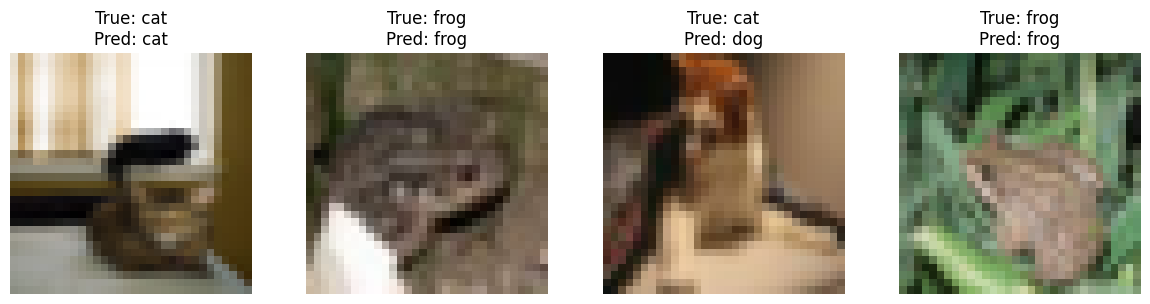

In [135]:
print("\nDisplaying random test images with predictions:")

# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 4 random indices from the batch
random_indices = random.sample(range(len(images)), 4)

# Get the selected images and labels
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Move selected images to the device for inference
selected_images_device = selected_images.to(device)

# Make predictions
net.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation for inference
    outputs = net(selected_images_device)

# Get the predicted class for each image
_, predicted = torch.max(outputs, 1)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # Hide axes
    plt.show()

# Display the 4 images with their ground truth and predicted labels
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    ax = axes[i]
    img = selected_images[i].cpu() # Move image back to CPU for plotting
    true_label = classes[selected_labels[i].cpu()] # Move label back to CPU
    predicted_label = classes[predicted[i].cpu()] # Move prediction back to CPU

    # Unnormalize and display the image
    img_unnormalized = img / 2 + 0.5
    npimg = img_unnormalized.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [121]:
# --- Evaluate the network on the test data ---
print("\nStarting Evaluation on Test Data")
net.eval() # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Calculate and print accuracy per class
print("\nAccuracy per class:")
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # Compare predictions with ground truth for each item in the batch
        c = (predicted == labels).squeeze()
        # Iterate through each item in the batch
        for i in range(labels.size(0)): # Use actual batch size here
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    # Avoid division by zero if a class has no samples in the test set (unlikely for CIFAR-10)
    if class_total[i] > 0:
        print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f}%')
    else:
        print(f'Accuracy of {classes[i]:5s} : N/A (no test samples)')


Starting Evaluation on Test Data
Accuracy of the network on the 10000 test images: 85.91%

Accuracy per class:
Accuracy of plane : 84.40%
Accuracy of car   : 93.00%
Accuracy of bird  : 81.50%
Accuracy of cat   : 70.20%
Accuracy of deer  : 91.40%
Accuracy of dog   : 78.00%
Accuracy of frog  : 87.40%
Accuracy of horse : 89.20%
Accuracy of ship  : 94.90%
Accuracy of truck : 89.10%


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


